Coffea Histograms
===============
This is a rendered copy of [histograms.ipynb](https://github.com/CoffeaTeam/coffea/blob/master/binder/histograms.ipynb). You can optionally run it interactively on [binder at this link](https://mybinder.org/v2/gh/coffeateam/coffea/master?filepath=binder%2Fhistograms.ipynb)

In scientific python, histograms seem to be considered as a plot style, on equal footing with, e.g. scatter plots.
It may well be that HEP is the only place where users need to plot *pre-binned* data, and thus must use histograms as persistent objects representing reduced data.  In Coffea, the [hist](https://coffeateam.github.io/coffea/modules/coffea.hist.html) subpackage provides a persistable mergable histogram object. This notebook will discuss a few ways that such objects can be manipulated.

A histogram object roughly goes through three stages in its life:
   - Filling
   - Transformation (projection, rebinning, integrating)
   - Plotting

We'll go over examples of each stage in this notebook, and conclude with some styling examples.

## Filling
Let's start with filling.  We'll use a random distribution [near and dear](https://en.wikipedia.org/wiki/ARGUS_distribution) to of b and c factory physicists, and have the numpy builtin [histogram function](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html) do the work for us:

In [1]:
import numpy as np
from scipy.stats import argus

vals = argus(chi=.5).rvs(size=1000)

hist = np.histogram(vals)
print(hist)

(array([ 21,  42,  64,  87, 117, 133, 163, 167, 132,  74]), array([0.01035199, 0.10884821, 0.20734443, 0.30584066, 0.40433688,
       0.5028331 , 0.60132932, 0.69982555, 0.79832177, 0.89681799,
       0.99531422]))


So we're done, right?
Probably not: we have more than 1000 events, and probably need to use some map-reduce paradigm to fill the histogram because we can't keep all 1 billion `vals` in memory.  So we need two things: a binning, so that all histograms that were independently created can be added, and the ability to add two histograms.

In [2]:
binning = np.linspace(0, 1, 50)

def add_histos(h1, h2):
    h1sumw, h1binning = h1
    h2sumw, h2binning = h2
    if h1binning.shape == h2binning.shape and np.all(h1binning==h2binning):
        return h1sumw+h2sumw, h1binning
    else:
        raise ValueError("The histograms have inconsistent binning")


In [3]:
vals2 = argus(chi=.5).rvs(size=1000)

hist1 = np.histogram(vals, bins=binning)
hist2 = np.histogram(vals, bins=binning)

hist = add_histos(hist1, hist2)
print(hist)

(array([ 2,  4, 10,  8, 18,  6, 12, 14, 24, 24, 16, 28, 30, 34, 26, 26, 32,
       46, 54, 18, 58, 42, 52, 46, 52, 44, 76, 48, 56, 66, 74, 72, 58, 62,
       84, 64, 70, 66, 58, 58, 66, 42, 50, 58, 44, 30, 36, 24, 12]), array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ]))


So now we have everything we need to make our own equivalent to ROOT TH1, from a filling perspective:

In [4]:
class myTH1:
    def __init__(self, binning):
        self._binning = binning
        self._sumw = np.zeros(binning.size - 1)
    
    def fill(self, values, weights=None):
        sumw, _ = np.histogram(values, bins=self._binning, weights=weights)
        self._sumw += sumw
    
    def __add__(self, other):
        if not isinstance(other, myTH1):
            raise ValueError
        if not np.array_equal(other._binning, self._binning):
            raise ValueError("The histograms have inconsistent binning")
        out = myTH1(self._binning)
        out._sumw = self._sumw + other._sumw
        return out

In [5]:
binning = np.linspace(0, 1, 50)

h1 = myTH1(binning)
h1.fill(vals)

h2 = myTH1(binning)
h2.fill(vals2)

h = h1 + h2
print(h._sumw)

[ 1.  5.  6. 12. 12.  9. 10. 21. 20. 23. 16. 26. 27. 36. 31. 31. 35. 43.
 46. 32. 52. 40. 54. 46. 52. 50. 60. 50. 49. 65. 65. 62. 61. 64. 74. 59.
 75. 71. 59. 66. 65. 47. 53. 58. 46. 34. 38. 27. 16.]


Homework: add `sumw2` support.

Of course, we might want multidimensional histograms.  There is `np.histogramdd`:

In [6]:
xyz = np.random.multivariate_normal(mean=[1, 3, 7], cov=np.eye(3), size=10000)

xbins = np.linspace(-10, 10, 20)
ybins = np.linspace(-10, 10, 20)
zbins = np.linspace(-10, 10, 20)
hnumpy = np.histogramdd(xyz, bins=(xbins, ybins, zbins))

but we are becoming challenged by book-keeping of the variables.
The [histogram class](https://coffeateam.github.io/coffea/api/coffea.hist.Hist.html#coffea.hist.Hist) in Coffea is designed to simplify this operation, and the eventual successor (for filling purposes) [boost-histogram](https://github.com/scikit-hep/boost-histogram#usage) has similar syntax.

In the constructor you specify each axis, either as a numeric `Bin` axis or a categorical `Cat` axis. Each axis constructor takes arguments similar to ROOT TH1 constructors. One can pass an array to the `Bin` axis for non-uniform binning. Then the fill call is as simple as passing the respective arrays to `histo.fill`.

In [7]:
import coffea.hist as hist

histo = hist.Hist("Counts",
                  hist.Cat("sample", "sample name"),
                  hist.Bin("x", "x value", 20, -10, 10),
                  hist.Bin("y", "y value", 20, -10, 10),
                  hist.Bin("z", "z value", 20, -10, 10),
                 )

histo.fill(sample="sample 1", x=xyz[:,0], y=xyz[:,1], z=xyz[:,2])

# suppose we have another sample of xyz values
xyz_sample2 = np.random.multivariate_normal(mean=[1, 3, 7], cov=np.eye(3), size=10000)

# additionally, lets assume entries in sample 2 have some non-uniform weight equal to atan(distance from origin)
weight = np.arctan(np.sqrt(np.power(xyz_sample2, 2).sum(axis=1)))

# weight is a reserved keyword in Hist, and can be added to any fill() call
histo.fill(sample="sample 2", x=xyz_sample2[:,0], y=xyz_sample2[:,1], z=xyz_sample2[:,2], weight=weight)

print(histo)

<Hist (sample,x,y,z) instance at 0x126fbb450>


In [8]:
# For more details, look at:
# help(hist.Hist)
# help(hist.Bin)
# help(hist.Cat)

## Transformation

Here are a few examples of transformations on multidimensional histograms in Coffea.  For each, the docstring (`help(function)` or shift+tab in Jupyter) provides useful info.

In [9]:
# sum all x bins within nominal range (-10, 10)
histo.sum("x", overflow='none')

<Hist (sample,y,z) instance at 0x12c740290>

There is some analog to fancy array slicing for histogram objects, which is supported (with reasonable consistency) in Coffea, where the slice boundaries are physical axis values, rather than bin indices.  All values outside the slice range are merged into overflow bins.

For a lengthy discussion on possible slicing syntax for the future, see [boost-histogram#35](https://github.com/scikit-hep/boost-histogram/issues/35).

In [10]:
sliced = histo[:,0:,4:,0:]
display(sliced)
display(sliced.identifiers("y", overflow='all'))

<Hist (sample,x,y,z) instance at 0x12ce48fd0>

[<Interval ((-inf, 4)) instance at 0x12ce64690>,
 <Interval ([4, 5)) instance at 0x12ce64b50>,
 <Interval ([5, 6)) instance at 0x12ce64b90>,
 <Interval ([6, 7)) instance at 0x12ce64bd0>,
 <Interval ([7, 8)) instance at 0x12ce64c10>,
 <Interval ([8, 9)) instance at 0x12ce64c90>,
 <Interval ([9, 10)) instance at 0x12ce64cd0>,
 <Interval ([10, inf)) instance at 0x12ce64d10>]

In [11]:
# integrate y bins from -2 to +10
histo.integrate("y", slice(0, 10))

<Hist (sample,x,z) instance at 0x12ce4bc50>

In [12]:
# rebin z axis by providing a new axis definition
histo.rebin("z", hist.Bin("znew", "rebinned z value", [-10, -6, 6, 10]))

<Hist (sample,x,y,znew) instance at 0x12ce64810>

In [13]:
# merge categorical axes
mapping = {
    'all samples': ['sample 1', 'sample 2'],
    'just sample 1': ['sample 1'],
}
histo.group("sample", hist.Cat("cat", "new category"), mapping)

<Hist (cat,x,y,z) instance at 0x12ceaae90>

In [14]:
# scale entire histogram by 3 (in-place)
histo.scale(3.)

In [15]:
# scale samples by different values (also in-place)
scales = {
    'sample 1': 1.2,
    'sample 2': 0.2,
}
histo.scale(scales, axis='sample')

In [16]:
# useful debugging tool: print bins, aka 'identifiers'
display(histo.identifiers('sample'))
display(histo.identifiers('x'))

[<StringBin (sample 1) instance at 0x126fbb7d0>,
 <StringBin (sample 2) instance at 0x126fbb650>]

[<Interval ([-10, -9)) instance at 0x12ceb7a50>,
 <Interval ([-9, -8)) instance at 0x12ceb7a90>,
 <Interval ([-8, -7)) instance at 0x12ceb7ad0>,
 <Interval ([-7, -6)) instance at 0x12ceb7b50>,
 <Interval ([-6, -5)) instance at 0x12ceb7bd0>,
 <Interval ([-5, -4)) instance at 0x12ceb7c10>,
 <Interval ([-4, -3)) instance at 0x12ceb7b10>,
 <Interval ([-3, -2)) instance at 0x12ceb7c90>,
 <Interval ([-2, -1)) instance at 0x12ceb7b90>,
 <Interval ([-1, 0)) instance at 0x12ceb7cd0>,
 <Interval ([0, 1)) instance at 0x12ceb7d10>,
 <Interval ([1, 2)) instance at 0x12ceb7d50>,
 <Interval ([2, 3)) instance at 0x12ceb7d90>,
 <Interval ([3, 4)) instance at 0x12ceb7dd0>,
 <Interval ([4, 5)) instance at 0x12ceb7e10>,
 <Interval ([5, 6)) instance at 0x12ceb7e50>,
 <Interval ([6, 7)) instance at 0x12ceb7e90>,
 <Interval ([7, 8)) instance at 0x12ceb7ed0>,
 <Interval ([8, 9)) instance at 0x12ceb7f10>,
 <Interval ([9, 10)) instance at 0x12ceb7f50>]

In [17]:
# bin contents are accessed using values
histo.sum('x', 'y').values(sumw2=False)

{('sample 1',): array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 3.60000e+00, 4.68000e+01, 7.56000e+02,
        4.96440e+03, 1.24128e+04, 1.21176e+04, 4.87080e+03, 7.88400e+02]),
 ('sample 2',): array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.45024293e+00, 1.14784307e+01, 2.00395495e+02, 1.19798066e+03,
        2.91584098e+03, 2.92899536e+03, 1.19559071e+03, 1.83424385e+02])}

In [18]:
# data can be exported to ROOT via uproot, but only 1D
import uproot
import os

if os.path.exists("output.root"):
    os.remove("output.root")

outputfile = uproot.create("output.root")
h = histo.sum('x', 'y')
for sample in h.identifiers('sample'):
    outputfile[sample.name] = hist.export1d(h.integrate('sample', sample))
outputfile.close()

## Plotting
The most integrated plotting utility in the scientific python ecosystem, by far, is [matplotlib](https://matplotlib.org/).  However, as we will see, it is not tailored to HEP needs.

Let's start by looking at basic mpl histogramming.

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

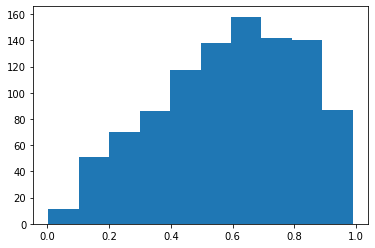

In [20]:
vals = argus(chi=.5).rvs(size=1000)

# notice the semicolon, which prevents display of the return values
plt.hist(vals);

Suppose we want to plot pre-binned data, for example from our earlier `np.histogram` usage.  Here we start running into the edge of typical mpl usage.  As mentioned before, apparently HEP is the only regular user of pre-binned histograms.

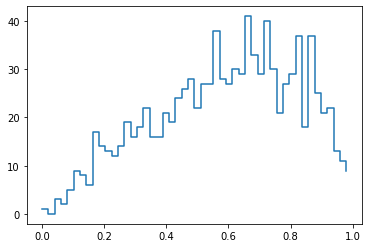

In [21]:
binning = np.linspace(0, 1, 50)

h1vals, h1bins = np.histogram(vals, bins=binning)
plt.step(x=h1bins[:-1], y=h1vals, where='post');

To facilitate these operations, there is a package called [mplhep](https://github.com/scikit-hep/mplhep). This package is available standlaone, but it is also used internally by the `coffea.hist` subpackage to provide several convenience functions to aid in plotting `Hist` objects:

 * [plot1d](https://coffeateam.github.io/coffea/api/coffea.hist.plot1d.html#coffea.hist.plot1d): Create a 1D plot from a 1D or 2D Hist object

 * [plotratio](https://coffeateam.github.io/coffea/api/coffea.hist.plotratio.html#coffea.hist.plotratio): Create a ratio plot, dividing two compatible histograms

 * [plot2d](https://coffeateam.github.io/coffea/api/coffea.hist.plot2d.html#coffea.hist.plot2d): Create a 2D plot from a 2D Hist object

 * [plotgrid](https://coffeateam.github.io/coffea/api/coffea.hist.plotgrid.html#coffea.hist.plotgrid): Create a grid of plots, enumerating identifiers on up to 3 axes
 
Below are some simple examples of using each function on our `histo` object.

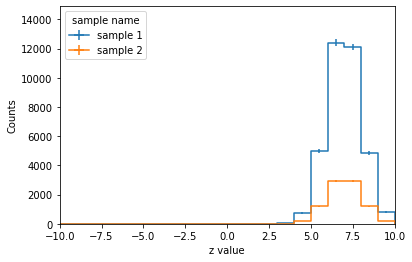

In [22]:
hist.plot1d(histo.sum("x", "y"), overlay='sample');

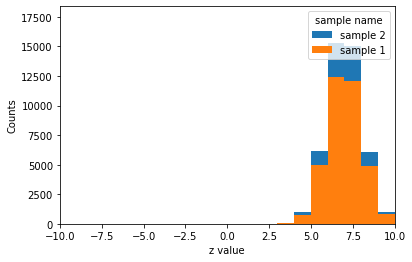

In [23]:
hist.plot1d(histo.sum("x", "y"), overlay='sample', stack=True);

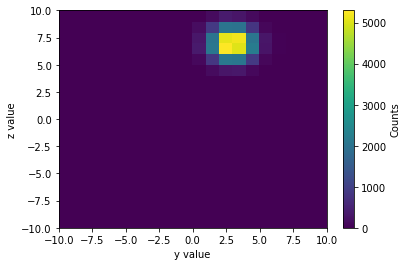

In [24]:
hist.plot2d(histo.sum('x', 'sample'), xaxis='y');

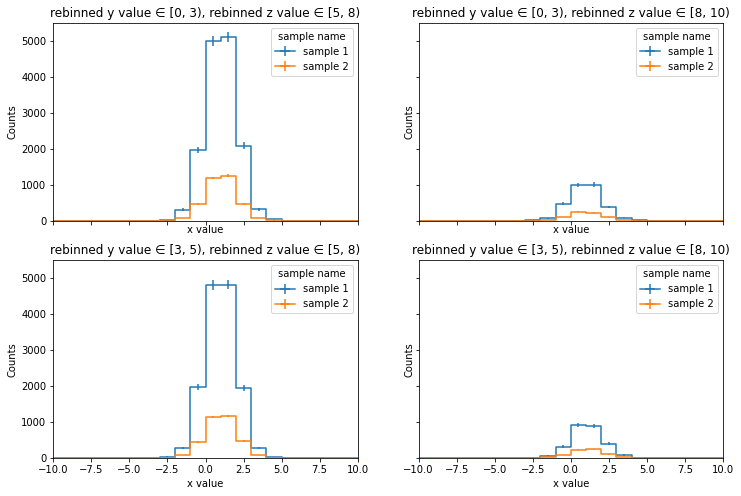

In [25]:
# make coarse binned hist and look at several distributions
hnew = (
    histo
    .rebin("y", hist.Bin("ynew", "rebinned y value", [0, 3, 5]))
    .rebin("z", hist.Bin("znew", "rebinned z value", [5, 8, 10]))
)

hist.plotgrid(hnew, row='ynew', col='znew', overlay='sample');

/Users/ncsmith/src/coffea/coffea/hist/plot.py:355: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


(-10.0, 10.0)

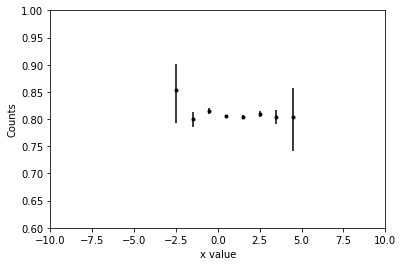

In [26]:
numerator = histo.integrate('sample', 'sample 1').sum('y', 'z')
denominator = histo.sum('sample', 'y', 'z')

numerator.title = r'$\epsilon$'
ax = hist.plotratio(
    num=numerator,
    denom=denominator,
    error_opts={'color': 'k', 'marker': '.'},
    unc='clopper-pearson'
)
ax.set_ylim(0.6, 1.)
ax.set_xlim(-10, 10)

## Styling

We've covered the basics of plotting, now let's go over some styling options. To make things more interesting, we'll load some electron and muon Lorentz vectors from simulated $H\rightarrow ZZ^{*}$ events into awkward arrays and then plot some kinematic quantities for them, making liberal use of the matplotlib styling options which are exposed through the coffea plotting utilities.

In [27]:
!curl -O http://scikit-hep.org/uproot/examples/HZZ.root

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  212k  100  212k    0     0  1062k      0 --:--:-- --:--:-- --:--:-- 1064k


In [28]:
import uproot
import awkward
from uproot_methods import TLorentzVectorArray

fin = uproot.open("HZZ.root")
tree = fin["events"]

# let's build the lepton arrays back into objects
# in the future, some of this verbosity can be reduced
arrays = {k.replace('Electron_', ''): v for k,v in tree.arrays("Electron_*", namedecode='ascii').items()}
p4 = TLorentzVectorArray.from_cartesian(
    arrays.pop('Px'),
    arrays.pop('Py'),
    arrays.pop('Pz'),
    arrays.pop('E'),
)
electrons = awkward.JaggedArray.zip(p4=p4, **arrays)

arrays = {k.replace('Muon_', ''): v for k,v in tree.arrays("Muon_*", namedecode='ascii').items()}
p4 = TLorentzVectorArray.from_cartesian(
    arrays.pop('Px'),
    arrays.pop('Py'),
    arrays.pop('Pz'),
    arrays.pop('E'),
)
muons = awkward.JaggedArray.zip(p4=p4, **arrays)

print("Avg. electrons/event:", electrons.counts.sum()/tree.numentries)
print("Avg. muons/event:", muons.counts.sum()/tree.numentries)

Avg. electrons/event: 0.07063197026022305
Avg. muons/event: 1.579925650557621


In [29]:
lepton_kinematics = hist.Hist(
    "Events",
    hist.Cat("flavor", "Lepton flavor"),
    hist.Bin("pt", "$p_{T}$", 19, 10, 100),
    hist.Bin("eta", "$\eta$", [-2.5, -1.4, 0, 1.4, 2.5]),
)

# Pass keyword arguments to fill, all arrays must be flat numpy arrays
# User is responsible for ensuring all arrays have same jagged structure!
lepton_kinematics.fill(
    flavor="electron",
    pt=electrons['p4'].pt.flatten(),
    eta=electrons['p4'].eta.flatten()
)
lepton_kinematics.fill(
    flavor="muon",
    pt=muons['p4'].pt.flatten(),
    eta=muons['p4'].eta.flatten()
)

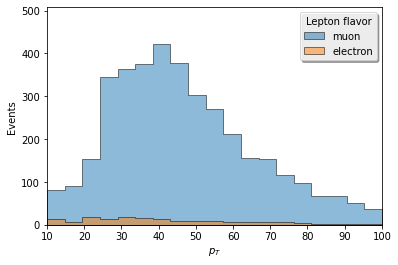

In [30]:
# Now we can start to manipulate this single histogram to plot different views of the data
# here we look at lepton pt for all eta
lepton_pt = lepton_kinematics.integrate("eta")

ax = hist.plot1d(
    lepton_pt,
    overlay="flavor",
    stack=True,
    fill_opts={'alpha': .5, 'edgecolor': (0,0,0,0.3)}
)
# all plot calls return the matplotlib axes object, from which
# you can edit features afterwards using matplotlib object-oriented syntax
# e.g. maybe you really miss '90s graphics...
ax.get_legend().shadow = True

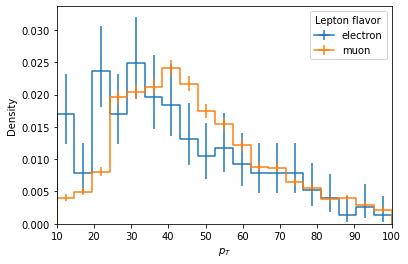

In [31]:
# Clearly the yields are much different, are the shapes similar? We can check by setting `density=True`
lepton_pt.label = "Density"
ax = hist.plot1d(lepton_pt, overlay="flavor", density=True)

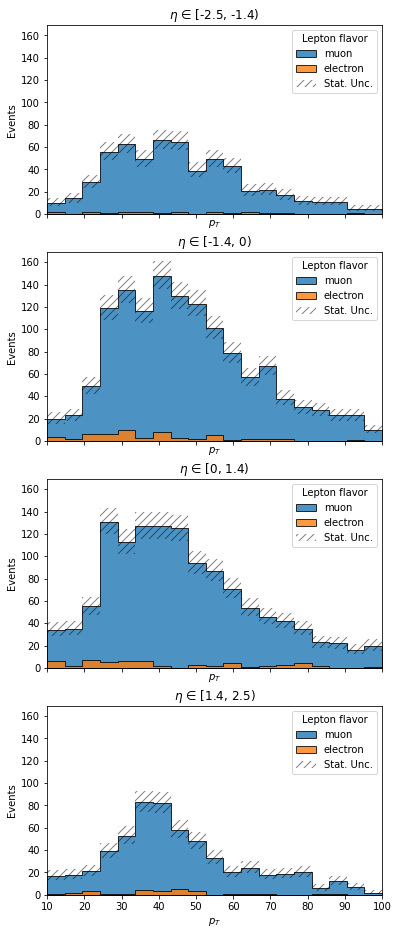

In [32]:
# Let's stack them, after defining some nice styling
stack_fill_opts = {
    'alpha': 0.8,
    'edgecolor':(0,0,0,.5)
}
stack_error_opts = {
    'label':'Stat. Unc.',
    'hatch':'///',
    'facecolor':'none',
    'edgecolor':(0,0,0,.5),
    'linewidth': 0
}
# maybe we want to compare different eta regions
# plotgrid accepts row and column axes, and creates a grid of 1d plots as appropriate
ax = hist.plotgrid(
    lepton_kinematics,
    row="eta",
    overlay="flavor",
    stack=True,
    fill_opts=stack_fill_opts,
    error_opts=stack_error_opts,
)

In [33]:
# Here we create some pseudodata for the pt histogram so we can make a nice data/mc plot
pthist = lepton_kinematics.sum('eta')
bin_values = pthist.axis('pt').centers()
poisson_means = pthist.sum('flavor').values()[()]
values = np.repeat(bin_values, np.random.poisson(poisson_means))
pthist.fill(flavor='pseudodata', pt=values)

# Set nicer labels, by accessing the string bins' label property
pthist.axis('flavor').index('electron').label = 'e Flavor'
pthist.axis('flavor').index('muon').label = r'$\mu$ Flavor'
pthist.axis('flavor').index('pseudodata').label = r'Pseudodata from e/$\mu$'

# using regular expressions on flavor name to select just the data
# another method would be to fill a separate data histogram
import re
notdata = re.compile('(?!pseudodata)')

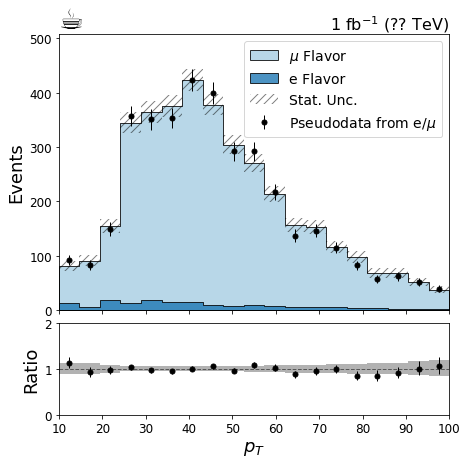

In [34]:
# make a nice ratio plot, adjusting some font sizes
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})
fig, (ax, rax) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(7,7),
    gridspec_kw={"height_ratios": (3, 1)},
    sharex=True
)
fig.subplots_adjust(hspace=.07)

# Here is an example of setting up a color cycler to color the various fill patches
# We get the colors from this useful utility: http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=6
from cycler import cycler
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']
ax.set_prop_cycle(cycler(color=colors))

fill_opts = {
    'edgecolor': (0,0,0,0.3),
    'alpha': 0.8
}
error_opts = {
    'label': 'Stat. Unc.',
    'hatch': '///',
    'facecolor': 'none',
    'edgecolor': (0,0,0,.5),
    'linewidth': 0
}
data_err_opts = {
    'linestyle': 'none',
    'marker': '.',
    'markersize': 10.,
    'color': 'k',
    'elinewidth': 1,
}

# plot the MC first
hist.plot1d(
    pthist[notdata], 
    overlay="flavor", 
    ax=ax,
    clear=False,
    stack=True, 
    line_opts=None,
    fill_opts=fill_opts,
    error_opts=error_opts
)
# now the pseudodata, setting clear=False to avoid overwriting the previous plot
hist.plot1d(
    pthist['pseudodata'],
    overlay="flavor",
    ax=ax,
    clear=False,
    error_opts=data_err_opts
)

ax.autoscale(axis='x', tight=True)
ax.set_ylim(0, None)
ax.set_xlabel(None)
leg = ax.legend()

# now we build the ratio plot
hist.plotratio(
    num=pthist['pseudodata'].sum("flavor"),
    denom=pthist[notdata].sum("flavor"), 
    ax=rax,
    error_opts=data_err_opts, 
    denom_fill_opts={},
    guide_opts={},
    unc='num'
)
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

# add some labels
coffee = plt.text(0., 1., u"☕",
                  fontsize=28, 
                  horizontalalignment='left', 
                  verticalalignment='bottom', 
                  transform=ax.transAxes
                 )
lumi = plt.text(1., 1., r"1 fb$^{-1}$ (?? TeV)",
                fontsize=16, 
                horizontalalignment='right', 
                verticalalignment='bottom', 
                transform=ax.transAxes
               )

Some further styling tools are available through the `mplhep` package. In particular, there are several stylesheets that update `plt.rcParams` to conform with experiment style recommendations regarding font face, font sizes, tick mark styles, and other such things. Below is an example application.

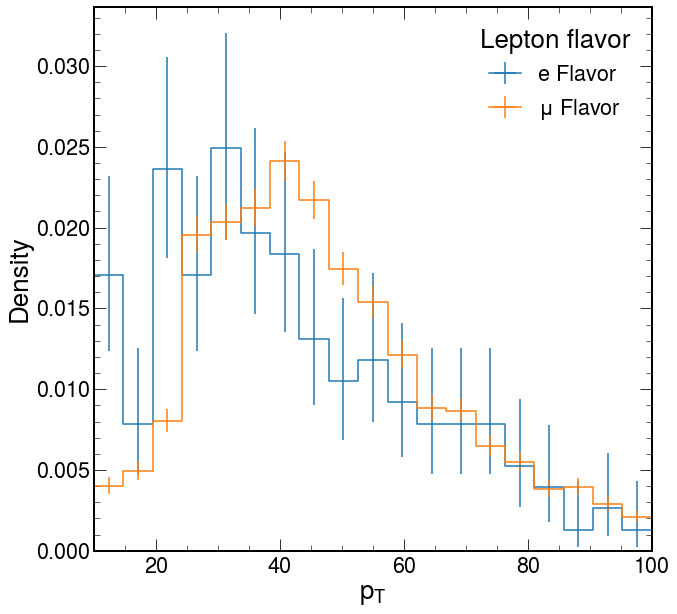

In [35]:
import mplhep
plt.style.use(mplhep.style.ROOT)

# Compare this to the style of the plot drawn previously
ax = hist.plot1d(lepton_pt, overlay="flavor", density=True)